# COMP41680 - Ryan Jennings 19205824

Import the standard packages for working with data for plotting and analysis

In [59]:
import csv
import re

from typing import Any, Dict, List, Tuple

import requests

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Ensure matplotlib version is > 3.1.1 or the plots will be offcentre

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Use seaborn style plots
sns.set()

JsonType = Dict[str, Any]

## Task 1
The 3 review categories I chose were:
- Gym
- Hotels
- Restaurants

In [3]:
def scrape_review(title: str) -> JsonType:
    """
    Scrape a review from the given samples based on category name

    Keyword arguments:
    title: str - The category name to scrape reviews for

    Return: JsonType - List of reviews in Dicts
    """
    scraped_data: JsonType = []
    home_url: str = "http://mlg.ucd.ie/modules/yalp/"
    url_map: Dict[str, str] = get_title_to_link_map(url=home_url)

    res = requests.get(f"{home_url}{url_map[title]}")
    category_page_soup = BeautifulSoup(res.text, 'html.parser')
    # Find all business links from the category
    review_links_page = category_page_soup.find_all('a', href=True)
    review_links: List[str] = [link['href'] for link in review_links_page][1:]
    for rlink in review_links:
        review_page = requests.get(f"{home_url}{rlink}")
        review_soup = BeautifulSoup(review_page.text, 'html.parser')
        # Find all individual reviews for the business
        reviews = review_soup.find_all("div", class_="review")

        # Seperate into text and rating (positive/negative)
        for review in reviews:
            review_rating = review.find('p', class_="rating").find('img')['alt'][0]
            review_text = review.find('p', class_="review-text")
            scraped_data.append({
                'text': review_text.text,
                'rating': (1 if int(review_rating) > 3 else 0) # 1 for a positive review, 0 for a negative review
            })
    return scraped_data

def get_title_to_link_map(url: str) -> Dict[str, str]:
    """
    For the main page get the title names and their corresponding links

    Keyword arguments:
    url: str - The base url for the category page

    Return: Dict[str, str] - Map of category names to category links
    """
    res = requests.get(url)
    html_soup: BeautifulSoup = BeautifulSoup(res.text, 'html.parser')
    links = html_soup.find_all('a', href=True)
    return {re.sub('Category: ', '', link.get_text()): link['href'] for link in links}

In [4]:
def write_scraped_data_to_csv(data: JsonType, file_name: str) -> None:
    """
    Write the ratings data into a csv file

    Keyword arguments:
    data: JsonType - List of rating Dicts to write to a csv file
    file_name: str - The name of the file to store the data in

    Return: None
    """
    with open(file_name, 'w') as csv_file:
        csv_writer = csv.DictWriter(csv_file, ['text', 'rating'], delimiter=',')
        csv_writer.writeheader()
        for row in data:
            csv_writer.writerow(row)

Call the scrape functions for the 3 selected topics

In [5]:
gym_data = scrape_review('Gym')

In [6]:
hotel_data = scrape_review('Hotels')

In [7]:
restaurant_data = scrape_review('Restaurants')

Write the scraped data into separate csv files

In [8]:
write_scraped_data_to_csv(data=gym_data, file_name='gym.csv')
write_scraped_data_to_csv(data=hotel_data, file_name='hotel.csv')
write_scraped_data_to_csv(data=restaurant_data, file_name='restaurant.csv')

## Task 2
For each of the three category datasets:
1. From the reviews in this category, apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.
2. Build a classification model to distinguish between “positive” and “negative” reviews using **one** of the following classifiers:  
       Naive Bayes, Logistic Regression, Random Forests
3. Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.

Start of exploratory data analysis by reading the csv scraped data into dataframes

In [9]:
gym_df = pd.read_csv('gym.csv')
hotel_df = pd.read_csv('hotel.csv')
rest_df = pd.read_csv('restaurant.csv')

The gyms on average higher more positive ratings. This could possibly be to the lower demands on gyms that just need to have good equipment and be clean while hotels and restaurants have to have a higher standard of hygiene and provide a high standard of food/facilities.  

In [10]:
print(f"Gyms positive rating percentage: {gym_df.mean()[0]*100:.2f}%")
print(f"Hotels positive rating percentage: {hotel_df.mean()[0]*100:.2f}%")
print(f"Restaurants positive rating percentage: {rest_df.mean()[0]*100:.2f}%")

Gyms positive rating percentage: 64.95%
Hotels positive rating percentage: 58.80%
Restaurants positive rating percentage: 58.10%


We can see in the subplots below the visual representation of the percentage positive ratings

Text(0.5, 0, 'Negative                                 Positive')

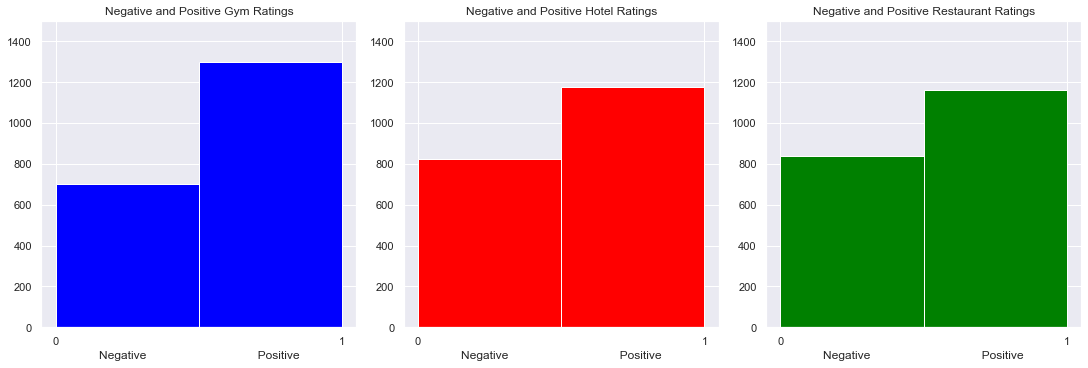

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, constrained_layout=True, figsize=(15, 5))
gym_df['rating'].hist(ax=ax0, bins=2, color='blue')
hotel_df['rating'].hist(ax=ax1, bins=2,color='red')
rest_df['rating'].hist(ax=ax2, bins=2, color='green')

ax0.set_ylim([0, 1500])
ax1.set_ylim([0, 1500])
ax2.set_ylim([0, 1500])
ax0.set_title('Negative and Positive Gym Ratings')
ax1.set_title('Negative and Positive Hotel Ratings')
ax2.set_title('Negative and Positive Restaurant Ratings')
ax0.set_xticks([0, 1])
ax1.set_xticks([0, 1])
ax2.set_xticks([0, 1])
ax0.set_xlabel('Negative                                 Positive')
ax1.set_xlabel('Negative                                 Positive')
ax2.set_xlabel('Negative                                 Positive')

The next step is to split up the scraped data into training and testing sets. With this we can evaluate the efficiency of our models by judging the model on our test data which we already know the correct answer for. For this I originally used the built in sklearn train_test_split but the accuracy of the final classification was 10% higher by manually splitting the data

In [13]:
def split_data(dataframe: pd.DataFrame, train_size: float = 0.9) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split the data into training and testing.
    I tried with the built-in sklearn `train_test_split` but doing it manually for some reason
    produced 10% better classification given the same split
    #train_gym_text, test_gym_text, train_gym_rating, test_gym_rating = \
      train_test_split(gym_df['text'], gym_df['rating'], test_size=0.1)

    Keyword argument:
    dataframe: pd.DataFrame - the DataFrame to split data for
    train_size: float - the percentage (out of 1.0) to use for training, default 90%

    Return: Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame] - Return 4 DataFrames split proportionally
    """
    por: int = int(round(dataframe['text'].count() * train_size))
    return dataframe['text'][:por], dataframe['text'][por:], dataframe['rating'][:por], dataframe['rating'][por:]

In [14]:
train_gym_text, test_gym_text, train_gym_rating, test_gym_rating = split_data(dataframe=gym_df)
train_hotel_text, test_hotel_text, train_hotel_rating, test_hotel_rating = split_data(dataframe=hotel_df)
train_rest_text, test_rest_text, train_rest_rating, test_rest_rating = split_data(dataframe=rest_df)

**Model**  
Here we are using a Multinomial Naive Bayes model to accuractely classify the positive and negative reviews. I have choosen Naive Bayes as I have previously made use of logistic regressions and random forests and wanted to increase my experience and knowledge with other classification models. I also found that Naive Bayes provided a high and effective classification accuracy that is detailed further below

**Prediction**  
For the prediction the model and vectorizer are injected in alone with whatever test text data we want to use and from this we return our predictions. After vectorizing our test text we simply just predict its rating using our model.

In [60]:
def generate_model(train_text: pd.DataFrame, train_rating: pd.DataFrame) -> Tuple[MultinomialNB, TfidfVectorizer]:
    """
    Generate the predictions based on the training data

    Keyword arguments:
    train_text: pd.DataFrame - The dataframe text for training
    train_rating: pd.DataFrame - The dataframe ratings for training

    Return:
    MultinomialNB - fitted Naive Bayes model
    TfidfVectorizer - Vectorizer that converts the document to a matrix of TF-IDF features
    """
    vectorizer = TfidfVectorizer(stop_words="english", min_df=10)

    train_X = vectorizer.fit_transform(train_text)
    train_Y = train_rating
    # print(f"Train data shape after vectorising: {train_X.shape}")

    model: MultinomialNB = MultinomialNB()
    model.fit(train_X, train_Y)
    return model, vectorizer

def generate_prediction(model: MultinomialNB, vec: TfidfVectorizer, test_text: pd.DataFrame) -> np.ndarray:
    """
    Generate a prediction array for a test text set

    Keyword arguments:
    model: MultinomialNB - The fitted Naive Bayes model
    vec: TfidVectorizer - The vectorizer for the model data
    test_text: pd.DataFrame - A dataframe of the test text set

    Return: np.ndarray - The predicted ratings from the fitted model
    """
    test_X = vec.transform(test_text)
    predicted_rating: np.ndarray = model.predict(test_X)
    return predicted_rating

In [58]:
gym_model, gym_vec = generate_model(train_text=train_gym_text,
                                    train_rating=train_gym_rating)
hotel_model, hotel_vec = generate_model(train_text=train_hotel_text,
                                        train_rating=train_hotel_rating)
rest_model, rest_vec = generate_model(train_text=train_rest_text,
                                      train_rating=train_rest_rating)

In [51]:
predicted_gym_rating: np.ndarray = generate_prediction(model=gym_model,
                                                       vec=gym_vec,
                                                       test_text=test_gym_text)
predicted_hotel_rating: np.ndarray = generate_prediction(model=hotel_model,
                                                         vec=hotel_vec,
                                                         test_text=test_hotel_text)
predicted_rest_rating: np.ndarray = generate_prediction(model=rest_model,
                                                        vec=rest_vec,
                                                        test_text=test_rest_text)

On the evaluation stage we take the actual ratings and the predicted ratings and see what analysis we can apply to evaluate accuracy. The first is a simple accuracy score that is built into sklearn which returns the percentage accuracy. Following this we produce an sklearn confusion matrix and plot it into a heatmap using seaborn.  
Dealing with gyms, hotels and restaurants we don't put too much emphasise on whether we would prefer to have less False Positives or False Negatives as you would for high importance medical programs. Although I have to say that I would prefer more False Negatives than False Positives to ensure you are picking the highest quality service and a bad one doesn't sneak in.

In [72]:
def evaluate(test_rating: pd.DataFrame, predicted_rating: np.ndarray, title: str = '') -> None:
    """
    Evaluate the model results and display

    test_rating: pd.DataFrame - The test ratings for the data

    Return: None
    """
    space: str = ' ' if title != '' else ''
    # Accuracy
    acc = accuracy_score(test_rating, predicted_rating)
    print(f"{title}{space}Review Classification accuracy: {acc:.2f}")
    # Confusion matrix
    print(f"Confusion matrix results: ")
    con_matrix: np.ndarray = confusion_matrix(test_rating, predicted_rating)
    print(con_matrix)
    print(f"True Negatives: {con_matrix[0][0]}")
    print(f"False Positives: {con_matrix[0][1]}")
    print(f"False Negatives: {con_matrix[1][0]}")
    print(f"True Positives: {con_matrix[1][1]}")
    # Heat map
    labels: List[str] = ['Negative', 'Positive']
    cm_df: pd.DataFrame = pd.DataFrame(con_matrix, index=labels, columns=labels)
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm_df, annot=True, fmt='g')
    ax.set(xlabel='Predicted', ylabel='Actual')

For the gym reviews we achieved a 90% accuracy score. The test set seems to have a very large percentage of positive tests. The hotel classifier model correctly predict 152/160 (95%) of positives but only 27/40 (68%) of negatives. This might be due to the lower amount of negative reviews to train on. Having a larger number of negative reviews could reduce the number of False Positives in our model

Gym Review Classification accuracy: 0.90
Confusion matrix results: 
[[ 27  13]
 [  8 152]]
True Negatives: 27
False Positives: 13
False Negatives: 8
True Positives: 152


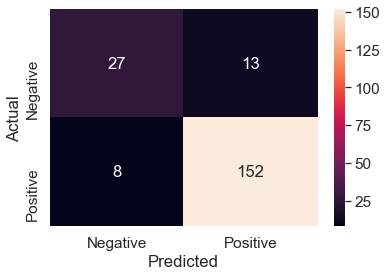

In [73]:
evaluate(test_rating=test_gym_rating, predicted_rating=predicted_gym_rating, title='Gym')

Moving onto the hotel data, the accuracy roughly matched the gym model accuracy, at 89%. The confusion matrix for hotels appears more accurate, possibly due to the increased amount of negative reviews for training. On the test data the model had a 125/138 (91%) accuracy for positive reviews and a 53/62 (85%) accuracy for negative reviews. This model is a lot more balanced and closer to what we are looking for in an ideal classification system.

Hotel Review Classification accuracy: 0.89
Confusion matrix results: 
[[ 53   9]
 [ 13 125]]
True Negatives: 53
False Positives: 9
False Negatives: 13
True Positives: 125


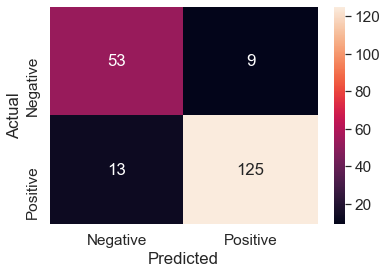

In [76]:
evaluate(test_rating=test_hotel_rating, predicted_rating=predicted_hotel_rating, title='Hotel')

Finally the 3rd category, the restaurant dataset. This category had the lowest accuracy. The lower accuracy may be expecting when taking into account the finesse involved with restaurant ratings where the majority of the rating goes to the quality of the food. On top of this everyone considering themselves a self styled food critic would lead to more diverse reviews with more diverse language particularly food centric words that appear in multiple documents but don't convey a positive or negative message which could affect false positives and false negatives.  
Below in the output of the evaluae method we see that the restaurant model achived an 84% accuracy score with 97/10

Restaurant Review Classification accuracy: 0.84
Confusion matrix results: 
[[72 26]
 [ 5 97]]
True Negatives: 72
False Positives: 26
False Negatives: 5
True Positives: 97


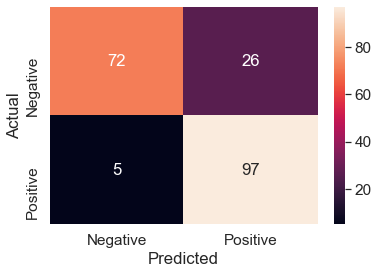

In [78]:
evaluate(test_rating=test_rest_rating, predicted_rating=predicted_rest_rating, title='Restaurant')

## Task 3
Evaluate the performance of each of your three classification models when applied to data from the other two selected categories. That is, for the selected categories (A, B, C), run the experiments:
1. Train a classification model on the performance on data from “Category A”. Evaluate its performance on data from "Category B” and data from “Category C”.  
2. Train a classification model on the performance on data from “Category B”. Evaluate its performance on data from "Category A” and data from “Category C”.  
3. Train a classification model on the performance on data from “Category C”. Evaluate its performance on data from "Category A” and data from “Category B”.  


In [20]:
# Evaluate the Gym model predictions on the Hotel and Restaurant data

In [21]:
# Evaluate the Hotel model predictions on the Gym and Restaurant data

In [22]:
# Evaluate the Restaurant model predictions on the Gym and Hotel data